In [7]:
import numpy as np

In [8]:
from numpy import pi, cos, sin, arccos, arange
import mpl_toolkits.mplot3d
import matplotlib.pyplot as pp

In [14]:
from colormath.color_objects import LabColor, HSVColor, sRGBColor
from colormath.color_diff import delta_e_cie1976, delta_e_cie1994

In [15]:
from colormath.color_conversions import convert_color

In [70]:
# Roughly number of unique colours in colourmapper.ini
H1 = [HSVColor(i, 1, 0.6) for i in np.linspace(0,360,20)]
H2 = [HSVColor(i, 1, 1) for i in np.linspace(0,360,20)]

In [71]:
def to_rgb(C):
    return C.rgb_r, C.rgb_g, C.rgb_b

In [72]:
R1 = [to_rgb(convert_color(h, sRGBColor)) for h in H1]
R2 = [to_rgb(convert_color(h, sRGBColor)) for h in H2]

In [73]:
r1 = [r[0] for r in R1], [r[1] for r in R1], [r[2] for r in R1]
r2 = [r[0] for r in R2], [r[1] for r in R2], [r[2] for r in R2]

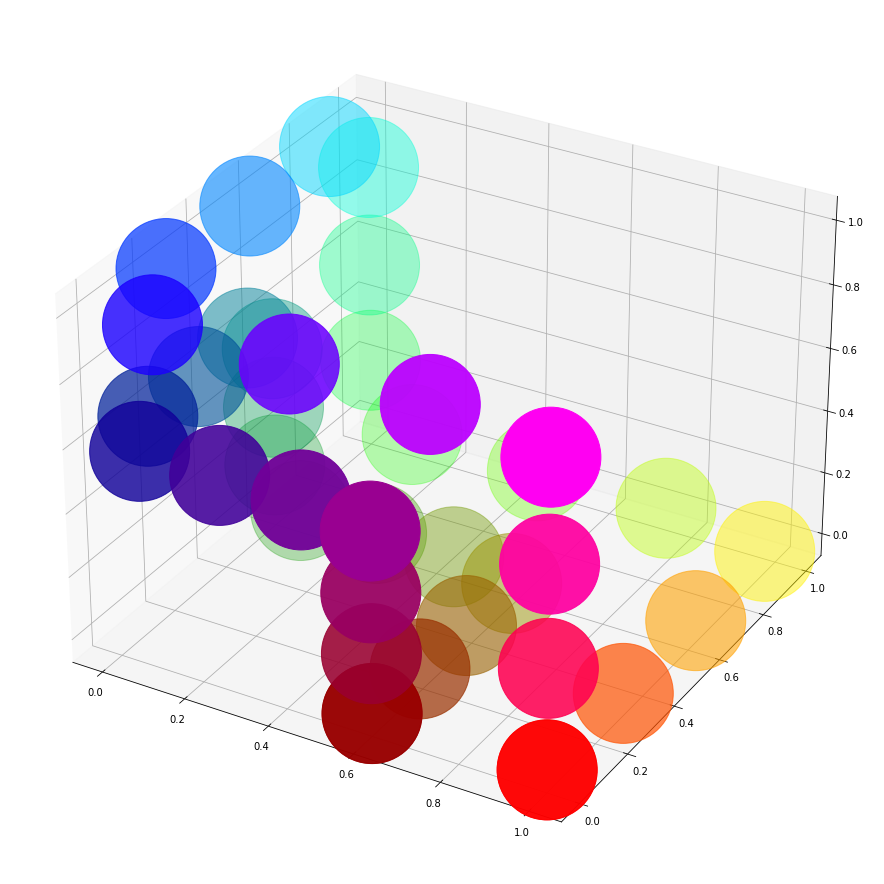

In [74]:
import matplotlib.pyplot as plt
pp = plt.figure(figsize=(16, 16))
ax = pp.add_subplot(111, projection='3d')
ax.scatter(*r1, c=list(zip(*r1)), s=10000)
ax.scatter(*r2, c=list(zip(*r2)), s=10000)

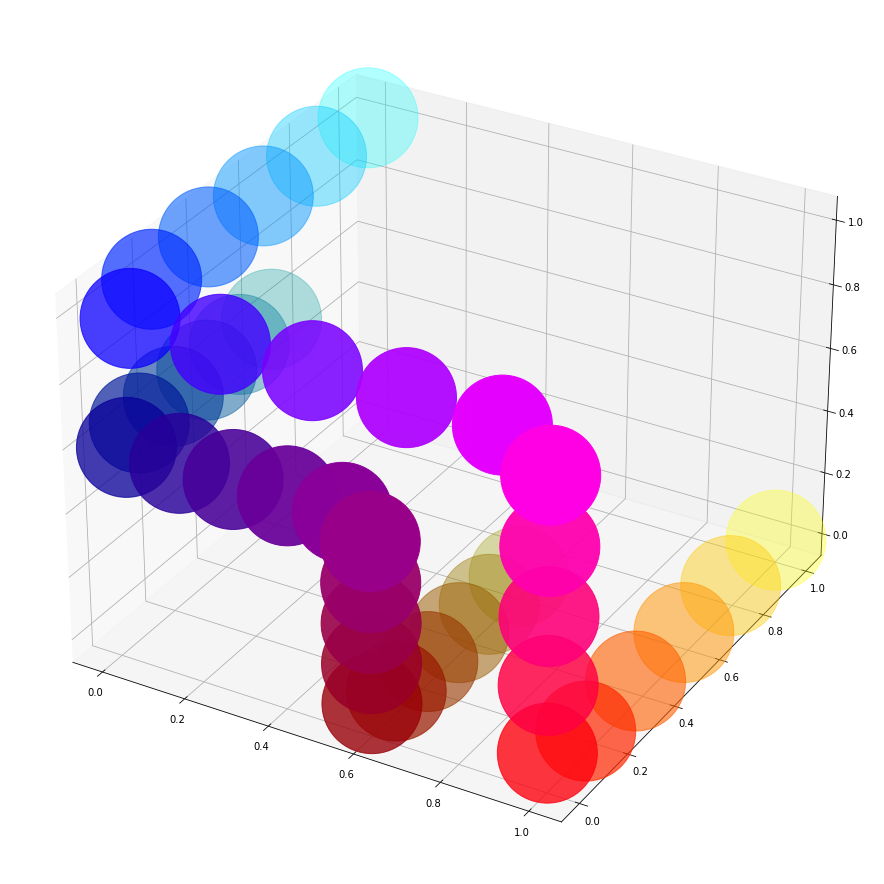

In [78]:
# correct for red-green colourblindness
gen_pal = lambda n, v, exclude: [HSVColor(i, 1, v) for i in np.linspace(exclude[1],360+exclude[0],n)] 
H1_cb = gen_pal(20,0.6, [60,180])
H2_cb = gen_pal(20,1, [60,180])

def to_rgb(C):
    return C.rgb_r, C.rgb_g, C.rgb_b

R1_cb = [to_rgb(convert_color(h, sRGBColor)) for h in H1_cb]
R2_cb = [to_rgb(convert_color(h, sRGBColor)) for h in H2_cb]

r1_cb = [r[0] for r in R1_cb], [r[1] for r in R1_cb], [r[2] for r in R1_cb]
r2_cb = [r[0] for r in R2_cb], [r[1] for r in R2_cb], [r[2] for r in R2_cb]

import matplotlib.pyplot as plt
pp = plt.figure(figsize=(16, 16))
ax = pp.add_subplot(111, projection='3d')
ax.scatter(*r1_cb, c=list(zip(*r1_cb)), s=10000)
ax.scatter(*r2_cb, c=list(zip(*r2_cb)), s=10000)

# Spiral 

In [85]:
# Create spiral in HV space
# Optimise number of revolutions,
#    start with single loop, m = 1
#    v = 1/m.(h/(360)) = mk,
#    dv = constant
# Optimise for H separation between points, 

In [104]:
def spiral_xy(a, m):
    # spiral function
    wt = 2*np.pi*a*m
    return a*np.cos(wt), a*np.sin(wt)

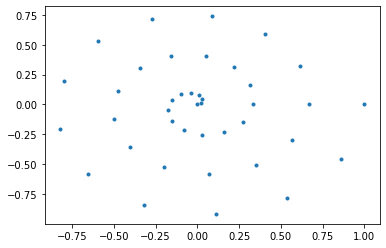

In [133]:
n = 40
a = np.linspace(0, 1, n)
plt.plot(*spiral_xy(a, 3), '.')

In [205]:
def spiral_a(r, m):
    return 2*np.pi*r*m

In [206]:
def spiral_xy(r, m):
    a = spiral_a(r, m)
    return r*np.cos(a), r*np.sin(a)

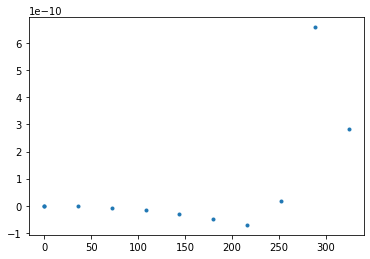

In [207]:
plt.plot(a*np.cos(2*np.pi*3*a), a*np.sin(2*np.pi*3*a), '.')

In [208]:
n = 11

In [216]:
def spiral_a(r, m):
    return 360*r*m % 360

In [288]:
r = np.linspace(0,1-1/n,n)
m = 3
a = spiral_a(r, m)

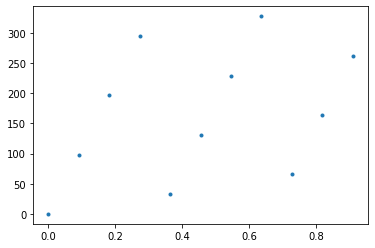

In [289]:
plt.plot(r, a, '.')

In [290]:
H_spiral = [HSVColor(h, 1, v) for h, v in zip(a, r)]

In [291]:
H_spiral[10]

HSVColor(hsv_h=261.81818181818176,hsv_s=1.0,hsv_v=0.9090909090909091)

In [292]:
def display_colours(HSV):

    def to_rgb(C):
        return C.rgb_r, C.rgb_g, C.rgb_b
    
    R1 = [to_rgb(convert_color(hsv, sRGBColor)) for hsv in HSV]
    
    import matplotlib.pyplot as plt
    pp = plt.figure(figsize=(16, 16))
    ax = pp.add_subplot(111, projection='3d')
    ax.scatter(*list(zip(*R1)), c=R1, s=10000)

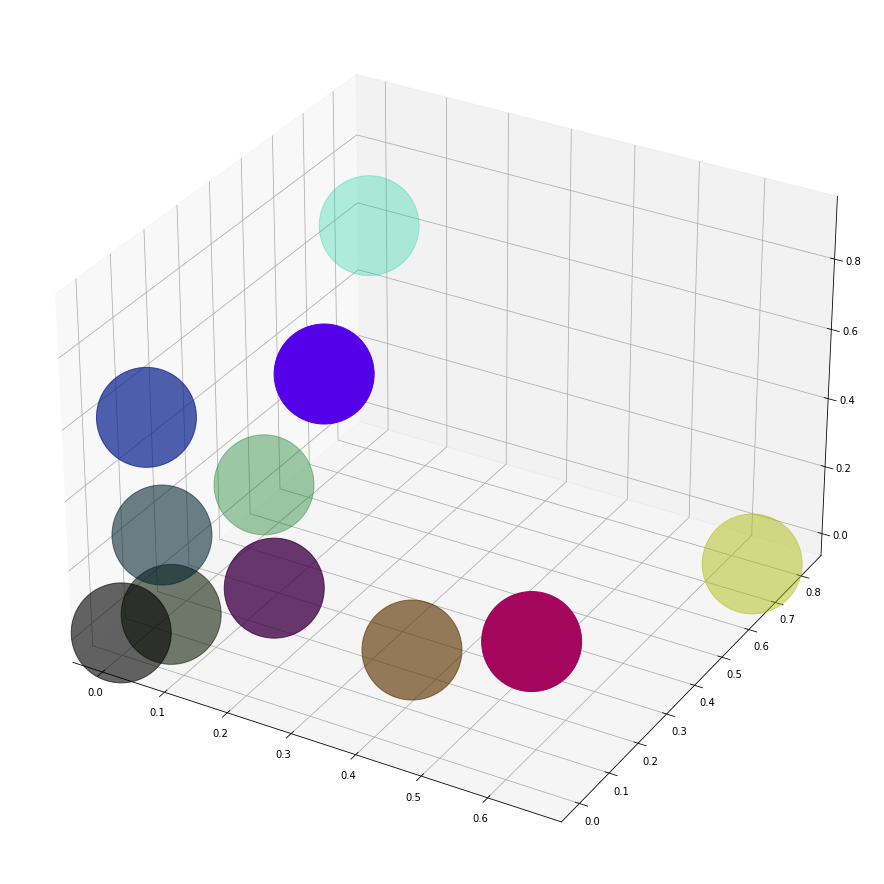

In [293]:
display_colours(H_spiral)

In [294]:
k = H_spiral[0]

In [295]:
k.hsv_h = 1

In [296]:
k.hsv_h

1

In [297]:
def lab_diff(H1, H2):
    L1 = convert_color(H1, LabColor)
    L2 = convert_color(H2, LabColor)
    return delta_e_cie1994(L1, L2)

In [298]:
lab_diff(H_spiral[-1], H_spiral[-2])

71.22939569704549

In [299]:
H = H_spiral

In [300]:
from itertools import combinations

In [301]:
def set_H(H, r, m):
    for h, hsv in zip(r, H):
        hsv.hsv_h = spiral_a(h, m)
        hsv.hsv_v = h

In [302]:
def obj(r):
    set_H(H, r, m)
    inds = list(range(len(H)))
    pairs = list(combinations(inds, r=2))
    return -np.sum(np.square([lab_diff(H[i], H[j]) for i, j in pairs]))

In [310]:
def obj(r):
    set_H(H, r, m)
    inds = list(range(len(H)))
    pairs = list(combinations(inds, r=2))
    return -np.sum(np.square([lab_diff(H[i], H[j]) for i, j in pairs]))/1e6

In [314]:
obj(r)

-0.23543417397946825

In [315]:
def jac(r):
    # Jacobian (gradient) with respect to each hue
    d = 0.01
    j = [None for i in r]
    r_shift = r[..., np.newaxis].repeat(r.size, axis=1) + d*np.identity(r.size)
    
    g = lambda r1, r2: (obj(r2) - obj(r1))/d
    
    for i in range(r.size):
        j[i] = g(r_shift[:,i], r)
    
    return j

In [316]:
%%timeit
jac(r)

196 ms ± 7.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [317]:
from scipy.optimize import minimize

In [318]:
r

array([0.        , 0.09090909, 0.18181818, 0.27272727, 0.36363636,
       0.45454545, 0.54545455, 0.63636364, 0.72727273, 0.81818182,
       0.90909091])

In [319]:
minimize(obj, r, jac=jac)

      fun: -0.2805923135771048
 hess_inv: array([[ 6.35302886e+00,  2.36230290e+00,  2.17941327e+00,
         1.90261982e+00, -1.63787133e+00,  3.32647616e+00,
        -1.30152269e+01, -1.07472539e-01, -2.12363875e+00,
         8.96309931e+00,  6.91454616e+00],
       [ 2.36230290e+00,  2.03835980e+00,  9.67871337e-01,
         8.26439393e-01, -7.22518707e-01,  1.46582000e+00,
        -5.73096005e+00, -3.93064318e-02, -9.25885639e-01,
         3.98799974e+00,  3.10329089e+00],
       [ 2.17941327e+00,  9.67871337e-01,  1.87833228e+00,
         7.94084660e-01, -6.67246305e-01,  1.35751752e+00,
        -5.31768912e+00, -5.57365761e-02, -8.81251743e-01,
         3.60116505e+00,  2.73862091e+00],
       [ 1.90261982e+00,  8.26439393e-01,  7.94084660e-01,
         1.63411021e+00, -5.81260427e-01,  1.17542224e+00,
        -4.58545834e+00, -1.22564162e-02, -7.18768216e-01,
         3.28976570e+00,  2.62337171e+00],
       [-1.63787133e+00, -7.22518707e-01, -6.67246305e-01,
        -5.81260427